In [ ]:
#모델 생성 및 학습

In [50]:
input_dim = 1 #입력하는 feature 개수
min_transaction_amount = 10000000 # 100만원 미만이면 리시버에서 버퍼로 데이터 안보내게끔.
n_cell = 32 # LSTM셀의 개수
seq_length = 60 # 모델이 참고 할 이전 분봉의 개수. LSTM/RNN에서
lr = 0.003 # 학습률
keep_prob = 1.0 #dropout rate
n_stacked_layers = 1 # 모델의 레이어 개수
n_epochs = 5 # 학습횟수. 얼리스타핑 넣을까말까
n_batch_size = 32 #학습 배치 사이즈
model_path = None

In [22]:
##########오전시간까지 포함된 데이터에 대해서###########
#################1분1초 3초 5초에 대한 코드 추가 -> 데이터확인해봐야함
import pandas as pd
import datetime
import numpy as np
import math
import openpyxl
import os
time_lst=[]
price_lst=[] #체결가
temp_lst=[] # 1: 매수 2:매도
amount_lst=[] #체결수량
state_lst=[]
feature_lst=[]
after_price_lst=[]
rate_lst=[]
label_lst=[]

def func1():
    file_name="./rawdata_concat.txt"
    in_file=open(file_name,"r") #file open

    in_str=in_file.read() #file read
    lst=in_str.split(')') # split
    new_lst=[]
    for el in lst :
        new_lst.append(el.lstrip(', ('))
    new_lst=list(filter(None,new_lst))
    #########################################리스트에 생성##################3
    time_lst=[]
    for el in new_lst:
        lst2 = el.split(',')
        #time=datetime.datetime.strptime(lst2[1].lstrip("' ").rstrip("' "),'%H%M%S')
        time = lst2[1].lstrip("' ").rstrip("' ")
        if(len(time)<14):
            time=time[:8]+'0'+time[8:13]
        time = datetime.datetime.strptime(time,"%Y%m%d%H%M%S")
        time_lst.append(time)  # 시간리스트에 추가
        price_lst.append(int(lst2[4]))  # 체결가 리스트에 추가
        amount_lst.append(int(lst2[8]))

        temp=lst2[6].lstrip(" '").rstrip(" '")
        state=int(temp)
        if(state==1) :
            state_lst.append(1)
        else:
            state_lst.append(-1)
    print(len(time_lst),len(price_lst),len(state_lst),len(amount_lst))
    time_lst = pd.to_datetime(time_lst)
    raw_data = {'time': time_lst, 'price': price_lst,'amount':amount_lst,'state':state_lst}
    data = pd.DataFrame(raw_data)

    in_file.close()
    return data
data1=func1()
#############체결가 X 체결량 X 상태 (피처값)열, 1분후 열 추가########################################
for i in range(len(data1)) :
    feature=data1.loc[i]['price'] *data1.loc[i]['amount'] * data1.loc[i]['state']
    #print(feature)
    feature_lst.append(feature)

    is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1)  # 각 행에대해서 1분 후의 가격이 존재하면 리스트에 추가
    temp = data1[is_time].reset_index(drop=True)
    if (temp.empty == False):
        after_price_lst.append(temp.loc[0]['price'])
    else:  # 1분후 값이 존재하지 않는 부분 1분 1초후 or  nan으로 채움
        is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1, seconds=1)
        temp = data1[is_time].reset_index(drop=True)
        if (temp.empty == False):
            after_price_lst.append(temp.loc[0]['price'])
        else:
            is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1, seconds=3)
            temp = data1[is_time].reset_index(drop=True)
            if (temp.empty == False):
                after_price_lst.append(temp.loc[0]['price'])
            else:
                is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1, seconds=5)
                temp = data1[is_time].reset_index(drop=True)
                if (temp.empty == False):
                    after_price_lst.append(temp.loc[0]['price'])
                else:
                    after_price_lst.append(np.nan)

data1['feature']=feature_lst
data1['1분후'] = after_price_lst
#############상승률 (label)열 추가########################################
for i in range(len(data1)):
    if(data1.loc[i]['1분후']!=np.nan) :
        rate=data1.loc[i]['1분후']/data1.loc[i]['price']
    else :
        rate=np.nan
    rate_lst.append(rate)
data1['label']=rate_lst

#print(data1.head(10))
###################################################임계치 넘는 값,  결측치 아닌값에 대해서만 train set을 df에저장
df=data1[abs(data1['feature'])>=min_transaction_amount]
df=df.dropna()
#print(df.head(20))



X_list=df.feature.tolist()
label_list=df.label.tolist()
print(len(X_list),len(label_list))

#################feature 값 3차원 array로 데이터 변환################

sample_num=0
feature_lst_3dim=[]
for i in range(len(X_list)-seq_length+1) :
        temp=X_list[i:i+seq_length] # temp는 1차원 list
        arr=np.array([temp]).T # arr는 temp를 배열로 변환후 transpose
        arr=arr.tolist() # 다시 리스트로 바꾸어
        feature_lst_3dim.append(arr) #최종 리스트에 추가
        sample_num=sample_num+1
print("데이터 샘플의 갯수: ",sample_num)
print("시계열의 크기 : ",seq_length)
X_arr=np.array(feature_lst_3dim) # list를 3차원 array로 변환
print(X_arr.shape)
#X_arr = feature 가 저장된 3차원 array
#################label 값 3차원 array로 데이터 변환################
label_len=0
label_lst_2dim=[]
for i in range(seq_length-1,len(label_list),1):
    temp=[]
    temp.append(label_list[i])
    label_lst_2dim.append(temp)
    label_len=label_len+1
Y_arr=np.array(label_lst_2dim)
print("라벨의 갯수: ",label_len)
print(Y_arr.shape)
#print(Y_arr)
# Y_arr = label이 저장된 3차원 array


base_dir="./"
file_nm="PreprocessingData.xlsx"
xlsx_dir=os.path.join(base_dir,file_nm)

df.to_excel(xlsx_dir)

252662 252662 252662 252662
32391 32391
데이터 샘플의 갯수:  32332
시계열의 크기 :  60
(32332, 60, 1)
라벨의 갯수:  32332
(32332, 1)


In [23]:
X_arr.shape

(32332, 60, 1)

In [116]:
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, Activation, LSTM
# Model Training & Saving
# 모델 생성 및 학습. 결과 저장

from keras import metrics

model = Sequential()
for i in range(n_stacked_layers):
    model.add(LSTM(n_cell, input_shape=(seq_length, input_dim), activation='sigmoid',weights=None))
model.add(Dense(1, input_shape=(1,)))
loss = 'mae'
optimizer='RMSprop'
model.compile(loss=loss, optimizer=optimizer)
#어떤 loss func, optimizer를 써야할지, 메트릭스를 써야할지 모르겠다. 일단 나중에 생각하기.
history = model.fit(x = X_arr, y = Y_arr, epochs = n_epochs, validation_split=0.3)
#밸리데이션셋은 이전 단계에서 햇음. 데이터를 트레인 테스트로 8:2로 나눈다음 8을 
#5.6 : 2.4로 트레인 : 밸릳 데이터로 나눔.

#모델 저장
model_path = f"./model_{loss}_{optimizer}_{datetime.datetime.now().strftime('%H%M%S')}.h5"
model.save(model_path)


#model.evaluate()
#model.save()

Train on 22632 samples, validate on 9700 samples
Epoch 1/5
22632/22632 [==============================] - 16s 725us/step - loss: 0.4718 - val_loss: 0.4327
Epoch 2/5
22632/22632 [==============================] - 17s 730us/step - loss: 0.3593 - val_loss: 0.4238
Epoch 3/5
22632/22632 [==============================] - 17s 741us/step - loss: 0.3583 - val_loss: 0.4221
Epoch 4/5
22632/22632 [==============================] - 16s 726us/step - loss: 0.3574 - val_loss: 0.4306
Epoch 5/5
22632/22632 [==============================] - 16s 725us/step - loss: 0.3571 - val_loss: 0.4276


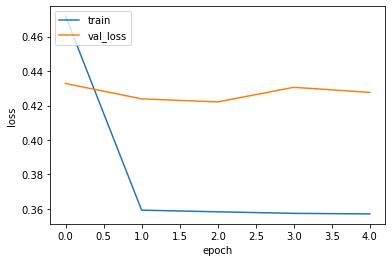

In [118]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val_loss'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'mae_RMSprop')

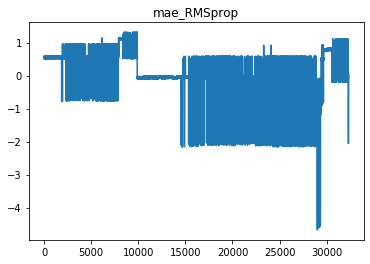

In [117]:
"""MAE + RMSprop"""
#목표오차 : 1e-4(0.0001, 0.01%, 1bp)
_ = model.predict(X_arr)
gap = _ - Y_arr #학습한 모델의 예측치와 실제 값의 차이
plt.plot(gap)
plt.title(loss+'_'+optimizer)

Text(0.5, 1.0, 'mae_adagrad')

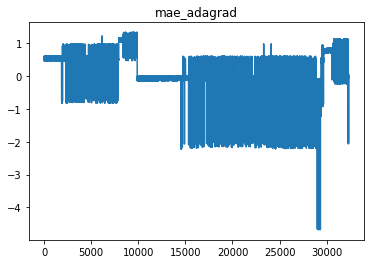

In [114]:
"""MAE + ADAGRAD"""
#목표오차 : 1e-4(0.0001, 0.01%, 1bp)
_ = model.predict(X_arr)
gap = _ - Y_arr #학습한 모델의 예측치와 실제 값의 차이
plt.plot(gap)
plt.title(loss+'_'+optimizer)

Text(0.5, 1.0, 'mae_adadelta')

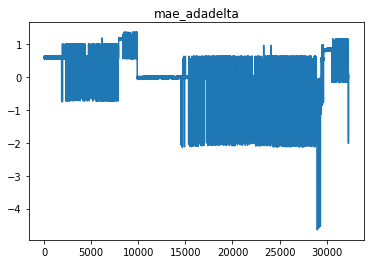

In [106]:
"""MAE + ADADELTA"""
#목표오차 : 1e-4(0.0001, 0.01%, 1bp)
_ = model.predict(X_arr)
gap = _ - Y_arr #학습한 모델의 예측치와 실제 값의 차이
plt.plot(gap)
plt.title(loss+'_'+optimizer)

In [97]:
gap[20000:20010]

array([[-0.60916395],
       [-0.60935517],
       [-0.6094286 ],
       [-0.00693803],
       [-0.0069481 ],
       [-0.00695192],
       [-0.60947134],
       [-0.00140738],
       [-0.00520652],
       [-0.60869749]])

In [112]:
Y_arr[20000:20010]

array([[1.60431655],
       [1.60431655],
       [1.60431655],
       [1.00179856],
       [1.00179856],
       [1.00179856],
       [1.60431655],
       [1.        ],
       [1.00179856],
       [1.60431655]])

In [76]:
_[1500:1550]

array([[0.9949614 ],
       [0.9985926 ],
       [0.99672234],
       [0.99659204],
       [0.9985926 ],
       [0.99672234],
       [0.99582577],
       [0.99545807],
       [0.99659204],
       [0.99561906],
       [0.9951526 ],
       [0.9985926 ],
       [0.99659204],
       [0.99561906],
       [0.9951526 ],
       [0.9949614 ],
       [0.9985926 ],
       [0.99672234],
       [0.99582577],
       [0.99545807],
       [0.99531704],
       [0.9952643 ],
       [0.9952448 ],
       [0.9952376 ],
       [0.99523497],
       [0.995234  ],
       [0.99523365],
       [0.9952335 ],
       [0.9952334 ],
       [0.99659204],
       [0.99561906],
       [0.9985926 ],
       [0.99672234],
       [0.99659204],
       [0.99561906],
       [0.9951526 ],
       [0.9985926 ],
       [0.99659204],
       [0.99561906],
       [0.9951526 ],
       [0.9949614 ],
       [0.99488795],
       [0.99486053],
       [0.99485046],
       [0.99484664],
       [0.9948452 ],
       [0.9985926 ],
       [0.996